In [0]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [6]:
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_JP_v1_00.tsv.gz -P data/
!gunzip -d data/amazon_reviews_multilingual_JP_v1_00.tsv.gz

--2020-04-30 05:36:53--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_JP_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.85.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.85.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94688992 (90M) [application/x-gzip]
Saving to: ‘data/amazon_reviews_multilingual_JP_v1_00.tsv.gz’

amazon_reviews_mult 100%[===================>]  90.30M  63.4MB/s    in 1.4s    

2020-04-30 05:36:55 (63.4 MB/s) - ‘data/amazon_reviews_multilingual_JP_v1_00.tsv.gz’ saved [94688992/94688992]



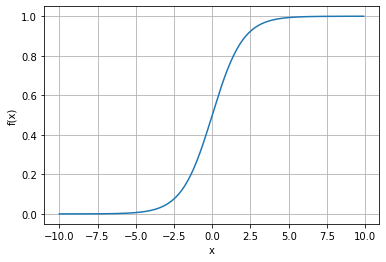

In [5]:
x = np.arange(-10, 10, 0.1)
f = 1 / (1 + np.exp(-x))

plt.grid()
plt.plot(x, f)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [7]:
import string
import pandas as pd
!pip install janome
from bs4 import BeautifulSoup
from janome.tokenizer import Tokenizer

t = Tokenizer(wakati = True)

def filter_by_ascii_rate(text, threshold = 0.9):
  ascii_letters = set(string.printable)
  rate = sum(c in ascii_letters for c in text) / len(text)
  return rate <= threshold


def load_dataset(filename, n=5000, state = 6):
  df = pd.read_csv(filename, sep = '\t')

  # マルチクラスに変更
  mapping = {1: 0, 2: 0, 4: 1, 5: 1}
  df = df[df.star_rating != 3]
  df.star_rating = df.star_rating.map(mapping)

  #日本語処理
  is_jp = df.review_body.apply(filter_by_ascii_rate)
  df = df[is_jp]

  # sampling
  df = df.sample(frac = 1, random_state = state)
  grouped = df.groupby('star_rating')
  df = grouped.head(n=n)
  return df.review_body.values, df.star_rating.values
def clean_html(html, strip = False):
  soup = BeautifulSoup(html, 'html.parser')
  text = soup.get_text(strip =  strip)
  return text
  
def tokenize(text):
  return t.tokenize(text)

     |████████████████████████████████| 21.5MB 1.6MB/s 


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score

In [8]:
def main():
  x, y = load_dataset("/content/data/amazon_reviews_multilingual_JP_v1_00.tsv", n = 5000)
  x = [clean_html(text, strip = True) for text in x]
  x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)


  vectorizer = TfidfVectorizer(tokenizer = tokenize)
  x_train_vec = vectorizer.fit_transform(x_train)
  x_test_vec = vectorizer.transform(x_test)


  clf = LogisticRegression(solver = 'liblinear')
  clf.fit(x_train_vec, y_train)

  y_pred = clf.predict(x_test_vec)
  score = accuracy_score(y_test, y_pred)
  print("Accuracy(test): {:.4f}".format(score))

if __name__ == "__main__":
    main()

Accuracy(test): 0.8440


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

def main():
  x, y = load_dataset("/content/data/amazon_reviews_multilingual_JP_v1_00.tsv", n = 5000)
  x = [clean_html(text, strip = True) for text in x]
  x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)


  vectorizer = TfidfVectorizer(tokenizer = tokenize)
  x_train_vec = vectorizer.fit_transform(x_train)
  x_test_vec = vectorizer.transform(x_test)


  clf = LogisticRegression(solver = 'liblinear')
  scores = cross_val_score(clf, x_train_vec, y_train, cv = 5)
  print(scores)
  print("Accuraecy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std() * 2))

  clf.fit(x_train_vec, y_train)
  y_pred = clf.predict(x_test_vec)
  score = accuracy_score(y_test, y_pred)
  print("Accuracy(test): {:.4f}".format(score))

if __name__ == "__main__":
    main()

[0.8175   0.83375  0.8225   0.8275   0.820625]
Accuraecy: 0.8244 (+/- 0.0114)
Accuracy(test): 0.8440


In [0]:
def plot_learning_curve(estimator, title, X, y, ylim = None, 
                        cv = None, n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel('Training examples')
  plt.ylabel("Score")

  train_sizes, train_scores, test_scores = learning_curve(
      estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
  train_scores_mean = np.mean(train_scores, axis = 1)
  train_scores_std = np.std(train_scores, axis = 1)
  test_scores_mean = np.mean(test_scores, axis = 1)
  test_scores_std = np.std(test_scores, axis = 1)
  plt.grid()


  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                   test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')
  plt.plot(train_sizes, train_scores_mean, 'o-', color ='r',
           label = 'Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g',
           label = 'Cross-validation score')
  plt.legend(loc = 'best')
  plt.show()

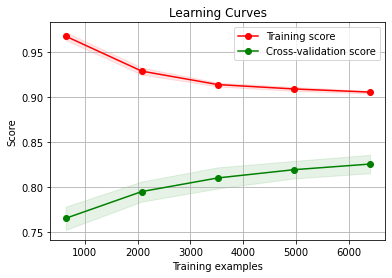

In [23]:
 from sklearn.model_selection import ShuffleSplit
 from sklearn.feature_extraction.text import TfidfVectorizer
 from sklearn.linear_model import LogisticRegression
 from sklearn.model_selection import train_test_split

 def main():
  x, y = load_dataset("/content/data/amazon_reviews_multilingual_JP_v1_00.tsv", n = 5000)
  x = [clean_html(text, strip = True) for text in x]
  x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)


  vectorizer = TfidfVectorizer(tokenizer = tokenize)
  x_train_vec = vectorizer.fit_transform(x_train)
  x_test_vec = vectorizer.transform(x_test)

  title = 'Learning Curves'
  cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
  clf = LogisticRegression(solver='liblinear')
  plot_learning_curve(clf, title, x_train_vec, y_train, cv=cv)

if __name__ == '__main__':
    main()